# First, let's import all the packages we need

In [2]:
# Set import directory up right
import sys
sys.path.append('./Python Implementation')

# For reproducibility, these will display the package versions I'm using
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [23]:
# Import some standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image
import glob
import timeit

In [121]:
# And let's import code that we ourselves wrote
from Scripts.nonparanormal_skeptic import nonparanormal_skeptic
from Scripts.EiGLasso import EiGLasso
from Scripts.utilities import binarize_matrix
from Scripts.antGLasso import antGLasso, antGLasso_heuristic, nmode_gram
from Scripts.nonparanormal_skeptic import nonparanormal_tensor_skeptic
from Scripts.generate_data import generate_Ys
from Scripts.utilities import reconstruct_axes, shuffle_axes

In [5]:
# Will automatically update this notebook's imports if import source code is changed.
%load_ext autoreload
%autoreload 2

In [19]:
# To render animations properly
%matplotlib notebook

# COIL Data
From the dataset available here: https://cave.cs.columbia.edu/repository/COIL-20

Store the downloaded `coil-20-proc` directory as a subdirectory of `Data`, which should share a parent with this notebook (i.e. `./Data/coil-20-proc` should access the file contents).

(72, 128, 128)


<IPython.core.display.Javascript object>


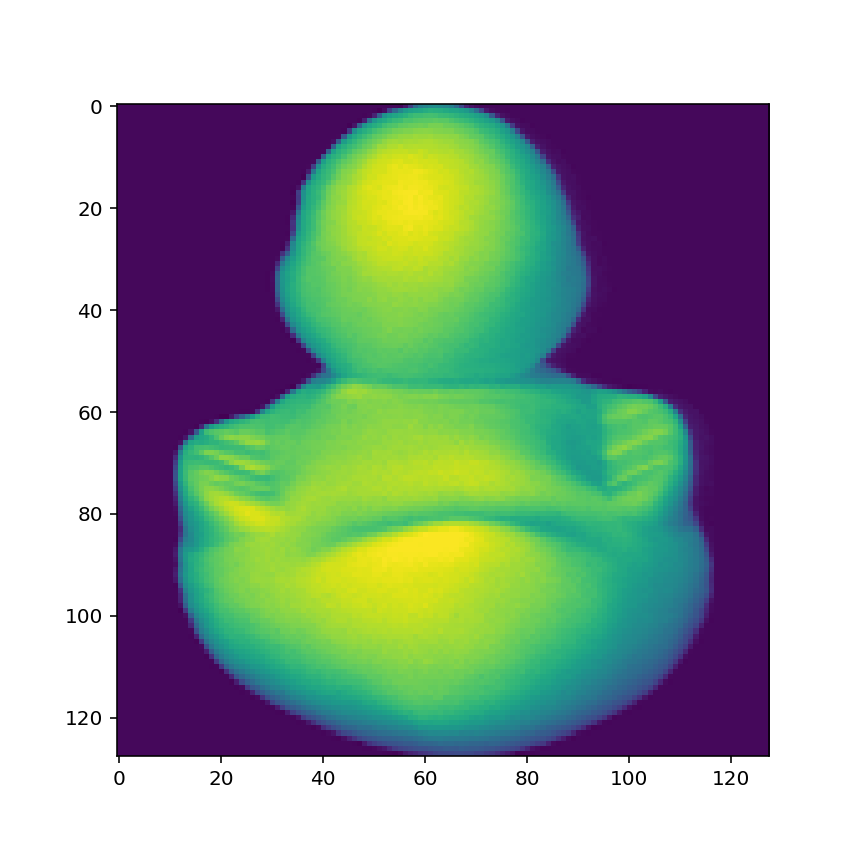

In [78]:
# Here we load the duck image.  In the BiGLasso paper, they considered 9 by 9
# pixel case with 36 frames.  Here, we consider the full 128x128x72 dataset.
# (The index of 10 is to grab the duck image)
import glob
def fix(x):
    # If filename contains single digit, append a 0
    if len(x.split('_')[-1].split('.')[0]) == 1:
        splate = x.split('_')
        splate[-1] = '0' + splate[-1]
        return '_'.join(splate)
    return x
globbed = glob.glob('./Data/coil-20-proc/*.png')
files = [(x, fix(x)) for x in globbed]
files.sort(key=lambda x:x[1])
duck_tens = np.array(
    [
        np.array(Image.open(f))[::imsize_factor, ::imsize_factor].reshape(imsize**2)
        for f, _ in files
    ],
    dtype=np.int16
).reshape((20, 72, 128, 128))[10]
print(duck_tens.shape) # object, frame, flattened pixel

fig, ax = plt.subplots(figsize=(6, 6))
mat = ax.imshow(duck_tens[0].reshape(imsize, imsize))
def update(idx):
    mat.set_data(duck_tens[idx].reshape(imsize, imsize)) 
    return [mat]

anim = FuncAnimation(fig, update, frames=72, interval = 5, blit=True)

# Demo 1: Is antGLasso faster than EiGLasso?
To test this, we combine the two pixel axes into one (since EiGLasso requires tensor dimensions of exactly 2)

Because it takes so long to run EiGLasso on the full dataset, we only look at every fourth element.  We also combine all C

In [95]:
def generate_timing_graph_smart(
    sizes,
    attempts, 
    m,
    df_scale,
    cutoff: "Amount of seconds before we stop considering it"=60,
    verbose=False
):
    include_sc = False
    include_eig = True
    include_an = False
    include_tera = False
    include_ant = True
    include_ant_high_b = True
    times_sc = []
    times_eig = []
    times_an = []
    times_tera = []
    times_ant = []
    times_ant_high_b = []
    for size in sizes:
        if not include_sc and not include_eig and not include_tera:
            # No need to do multiple attempts for
            # the non-iterative antGLasso algorithms
            attempts=1
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        if include_an:
            times_an.append(0)
        if include_eig:
            times_eig.append(0)
        if include_tera:
            times_tera.append(0)
        if include_ant:
            times_ant.append(0)
        if include_ant_high_b:
            times_ant_high_b.append(0)
        (Psi, Theta), Ys = generate_Ys(
            m=m,
            ds=[size, size],
            expected_nonzero=size**2 / 5,
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_anBiGLasso():
            anBiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                B_approx_iters = 10
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        def time_TeraLasso():
            TeraLasso(
                Ys,
                np.array(
                    [0.01, 0.01],
                    dtype=np.float64
                )
            )
        def time_antGLasso():
            antGLasso(
                Ys = Ys,
                betas = [0.01, 0.01],
                B_approx_iters = 10
            )
        def time_antGLasso_high_b():
            antGLasso(
                Ys = Ys,
                betas = [0.01, 0.01],
                B_approx_iters = 1000
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
            if times_sc[-1] >= cutoff:
                include_sc = False
        if include_an:
            timer = timeit.Timer(time_anBiGLasso)
            times_an[-1] = timer.timeit(attempts) / attempts
            if times_an[-1] >= cutoff:
                include_an = False
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
            if times_eig[-1] >= cutoff:
                include_eig = False
        if include_tera:
            timer = timeit.Timer(time_TeraLasso)
            times_tera[-1] = timer.timeit(attempts) / attempts
            if times_tera[-1] >= cutoff:
                include_tera = False
        if include_ant:
            timer = timeit.Timer(time_antGLasso)
            times_ant[-1] = timer.timeit(attempts) / attempts
            if times_ant[-1] >= cutoff:
                include_ant = False
        if include_ant_high_b:
            timer = timeit.Timer(time_antGLasso_high_b)
            times_ant_high_b[-1] = timer.timeit(attempts) / attempts
            if times_ant_high_b[-1] >= cutoff:
                include_ant_high_b = False
        if verbose:
            print(
                (f"\n\tSc : {times_sc[-1]} Seconds" if include_sc else "")
                + (f"\n\tAn: {times_an[-1]} Seconds" if include_an else "")
                + (f"\n\tAnt (b=10): {times_ant[-1]} Seconds" if include_ant else "")
                + (f"\n\tAnt (b=1000): {times_ant_high_b[-1]} Seconds" 
                   if include_ant_high_b else "")
                + (f"\n\tEig : {times_eig[-1]} Seconds" if include_eig else "")
                + (f"\n\tTera : {times_tera[-1]} Seconds" if include_tera else "")
            )
    print("Done")
    return times_sc, times_an, times_ant, times_ant_high_b, times_eig, times_tera

In [97]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'hard' distribution")
sizes_for_hard_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200
]
sc_hard_small, an_hard_small, ant_hard_small, ant_b_hard_small, eig_hard_small, tera_hard_small = \
    generate_timing_graph_smart(
        sizes_for_hard_small,
        attempts,
        df_scale=1,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'hard' distribution
Starting size=20

	Ant (b=10): 0.0044855419996565615 Seconds
	Ant (b=100): 0.16045195900005638 Seconds
	Eig : 2.598035792000246 Seconds
Starting size=40

	Ant (b=10): 0.006832832999862148 Seconds
	Ant (b=100): 0.18783779100022002 Seconds
	Eig : 2.082939625000108 Seconds
Starting size=60

	Ant (b=10): 0.051985583000259794 Seconds
	Ant (b=100): 0.19446633300003668 Seconds
	Eig : 3.520830667000155 Seconds
Starting size=80

	Ant (b=10): 0.036604166999950394 Seconds
	Ant (b=100): 0.19010858399997232 Seconds
	Eig : 6.38647441699959 Seconds
Starting size=100

	Ant (b=10): 0.01696270899992669 Seconds
	Ant (b=100): 0.19544420800002626 Seconds
	Eig : 6.416924832999939 Seconds
Starting size=125

	Ant (b=10): 0.034158375000060914 Seconds
	Ant (b=100): 0.20683608399986042 Seconds
	Eig : 11.174809790999916 Seconds
Starting size=150

	Ant (b=10): 0.03404079099982482 Seconds
	Ant (b=100): 0.22618504199999734 Seconds
	Eig : 18.164393582999764 Seconds
Starting

# Demo 2: Can antGLasso recover video data?

In [150]:
mixed = shuffle_axes(duck_tens, axes=[0])#[0, 1, 2])

In [167]:
Psis = antGLasso_heuristic(
    nonparanormal_tensor_skeptic(mixed[np.newaxis, ...]),
    sparsities=[1, 1, 1],
    B_approx_iters=1000
)
unmixed, order = reconstruct_axes(
    duck_tens[np.newaxis, ...],
    [1, 2, 3],
    Psis=Psis,
    return_order=True,
    first_idx=0
)
print(order)
unmixed = mixed[order[0]]
unmixed = unmixed[:, order[1]]
unmixed = unmixed[:, :, order[2]]

[[0, 62, 10, 41, 45, 63, 33, 30, 18, 53, 46, 8, 12, 43, 51, 21, 5, 4, 32, 44, 23, 1, 19, 40, 11, 28, 26, 49, 25, 9, 64, 67, 6, 48, 35, 57, 52, 13, 66, 55, 47, 16, 54, 14, 7, 65, 58, 22, 56, 59, 68, 2, 20, 15, 31, 42, 60, 34, 27, 70, 37, 71, 17, 36, 69, 50, 61, 29, 38, 24, 39, 3], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 

<IPython.core.display.Javascript object>


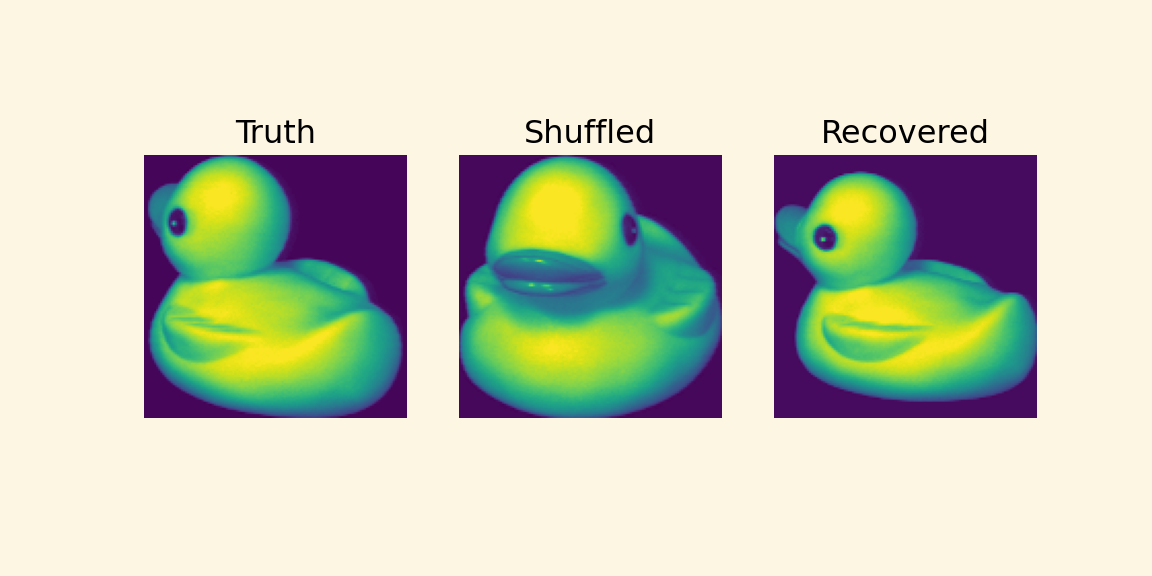

In [170]:
# All together demo

with plt.style.context('Solarize_Light2'):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(8, 4))
    
    true_duckie = ax1.imshow(duck_tens[0])
    ax1.grid(False)
    ax1.axis('off')
    ax1.set_title('Truth')
    
    mixed_duckie = ax2.imshow(mixed[0])
    ax2.grid(False)
    ax2.axis('off')
    ax2.set_title('Shuffled')
    
    recovered_duckie = ax3.imshow(unmixed[0])
    ax3.grid(False)
    ax3.axis('off')
    ax3.set_title('Recovered')

    def update(idx):
        true_duckie.set_data(duck_tens[idx])
        mixed_duckie.set_data(mixed[idx])
        recovered_duckie.set_data(unmixed[idx])
        return [true_duckie, mixed_duckie, recovered_duckie]

    anim = FuncAnimation(fig, update, frames=mixed.shape[0], interval = 5, blit=True)